<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/05_transfer_learning_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt



## Creating helpful functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-02 22:47:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-02 22:47:10 (89.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get data
**Using inbuild pretrained models from `tf.keras.applications`**

In [4]:
# Get 10% of traning data of food class

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-03-02 22:47:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.2MB/s    in 8.5s    

2024-03-02 22:47:21 (18.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
unzip_data("10_food_classes_10_percent.zip")

In [7]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Setup data

In [8]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE,
                                                               shuffle=True,
                                                               label_mode="categorical")


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE,
                                                               shuffle=True,
                                                               label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Keras Functional API - Can create more complex models
**Keras Functional API vs Sequential API**
`base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)`

## Model 0: Using keras functional api

In [18]:
# Create base model with tf.keras.application
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Freeze the base model (weights are not updated during training)
base_model.trainable = False

# Creat inputs into model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base_model
x = base_model(inputs)

# Average Pool
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Create the ouput activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs and outputs
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_0 = model_0.fit(train_data, epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=len(0.25 * test_data),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10% feature extraction")])

Saving TensorBoard log files to: transfer_learning/10% feature extraction/20240302-225121
Epoch 1/5
24/24 [==============================] - 28s 614ms/step - loss: 1.8916 - accuracy: 0.4280 - val_loss: 1.3373 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 7s 302ms/step - loss: 1.1394 - accuracy: 0.7800 - val_loss: 0.8953 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 7s 280ms/step - loss: 0.8317 - accuracy: 0.8333 - val_loss: 0.7181 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 8s 325ms/step - loss: 0.6705 - accuracy: 0.8627 - val_loss: 0.6234 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 8s 323ms/step - loss: 0.5712 - accuracy: 0.8760 - val_loss: 0.5638 - val_accuracy: 0.8668


In [19]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.5638 - accuracy: 0.8668


[0.5637509822845459, 0.8668000102043152]

In [20]:
model_0.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


## Printing layers from base model resnet

In [22]:
base_model.layers

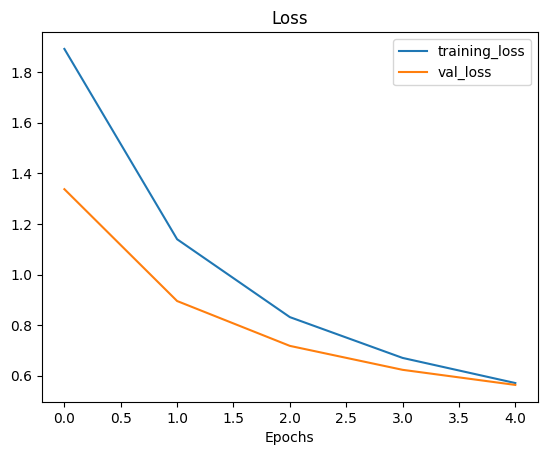

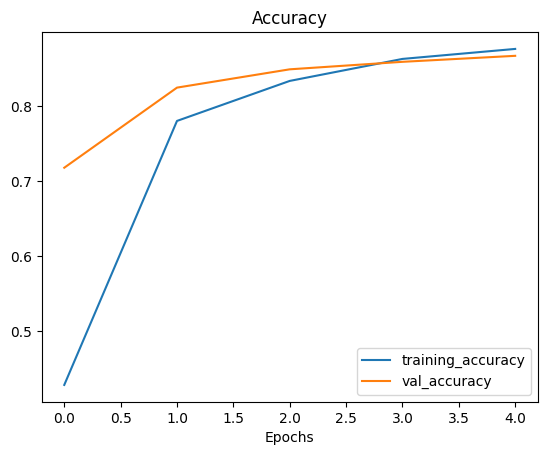

In [24]:
plot_loss_curves(history_model_0)

## Getting feature vector from trained model

In [29]:
input_shape = (1, 4, 4, 3)
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"{input_tensor}")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"{global_average_pooled_tensor}")

[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
[[-0.09368646 -0.45840448 -0.2885598 ]]


In [31]:
# Replicate what GlobalAveragePooling2D in simple code
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the traning data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the traning with data augmentation
3.  `model_3` - fine-tunning  
4. `model_4` - fine-tunning and 100% training data

### Model_1 - Get the data

In [33]:
# Download and prepare data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

train_dir = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

--2024-03-02 23:33:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  22.4MB/s    in 7.1s    

2024-03-02 23:33:35 (18.0 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [34]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [35]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Model 1 - Model creation with data augmentation inside model creation

**Benefit of this is way of doing data augmentation is it can utilize GPU**

In [52]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255)
], name="data_augmentation")

#### Visualize the data augmentation

Text(0.5, 1.0, 'Augmented image')

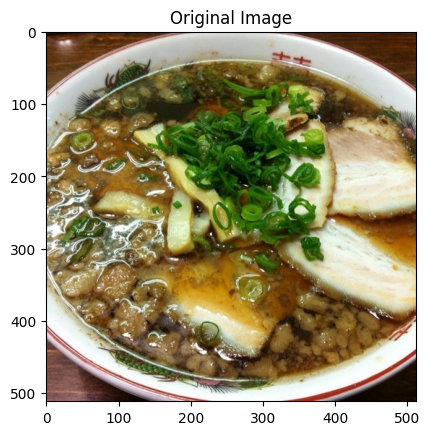

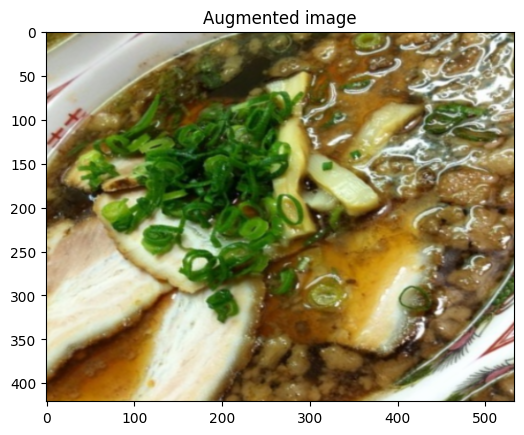

In [55]:
import os
import random
import matplotlib.image as mpimg

target_class = random.choice(train_data.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original Image")

augmentation_image = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmentation_image)
plt.title("Augmented image")

### Model 1 - Feature extraction transfer learning on 1% of data

In [66]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
output_layer = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(input_layer, output_layer)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_1 = model_1.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_per_data_aug")]
                              )

Saving TensorBoard log files to: transfer_learning/1_per_data_aug/20240303-004124
Epoch 1/5
3/3 [==============================] - 16s 3s/step - loss: 2.3400 - accuracy: 0.1000 - val_loss: 2.3270 - val_accuracy: 0.0872
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.3387 - accuracy: 0.0714 - val_loss: 2.3254 - val_accuracy: 0.1118
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 2.3501 - accuracy: 0.0429 - val_loss: 2.3255 - val_accuracy: 0.1036
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 2.3492 - accuracy: 0.0857 - val_loss: 2.3223 - val_accuracy: 0.1003
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 2.3743 - accuracy: 0.1000 - val_loss: 2.3279 - val_accuracy: 0.1086


In [67]:
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [68]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 2.3420 - accuracy: 0.1000


[2.3420488834381104, 0.10000000149011612]

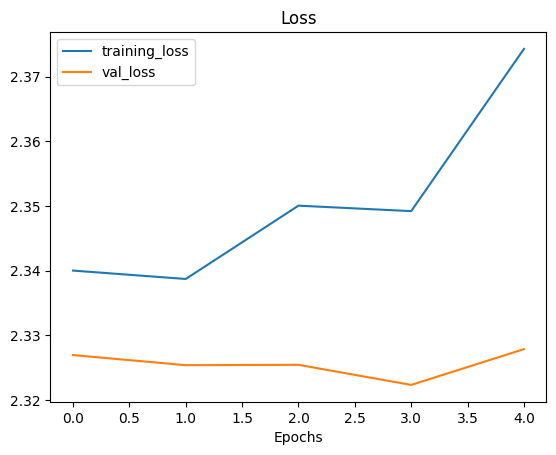

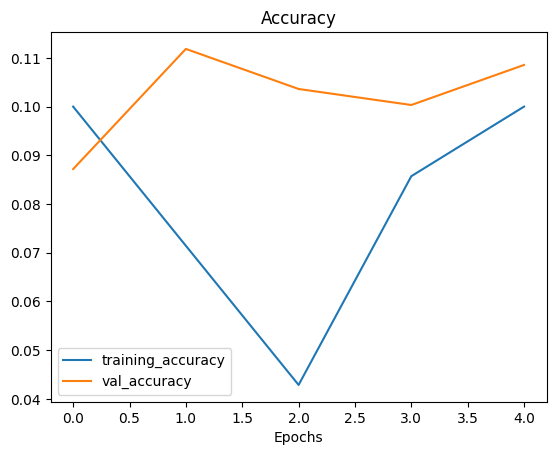

In [69]:
plot_loss_curves(history_model_1)

### Model 2 - 10% data with data augmentation layer

**What is new? -> Model Checkpoints callbacks and 10% data**

In [70]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"
input_shape = (224, 224, 3)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="categorical")

# Check training data directory
walk_through_dir(train_dir)

# Create data augmentation sequential layer
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescaling(1./255)
], name="data_augmentation")


base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Step 1 - Create inputs
input_layer = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(input_layer)

# Step 2 - Setup Base model
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Step 3 - Create output layer
output_layer = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Step 4 - combine the layers
model_2 = tf.keras.Model(input_layer, output_layer)

# Compile the model 2

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_2 = model_2.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_per_data_aug")]
                              )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_class

AttributeError: module 'tensorflow.keras.layers' has no attribute 'GlobalAveragePooling2d'